In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import os
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold
import gc
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.mode.chained_assignment = None

/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv


In [2]:
path = '/kaggle/input/heart-disease-prediction-using-logistic-regression'

In [3]:
def loader(path = path):
    data = pd.read_csv(os.path.join(path, 'framingham.csv'))

    data['age_binned'] = pd.cut(data['age'], 8)
    
    numeric_col = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
    categoric_col = [x for x in data.columns if x not in numeric_col and x!='TenYearCHD']

    data[categoric_col] = data[categoric_col].astype(str, copy = True)
    data[categoric_col].fillna('missing', inplace = True)
    
    chosen_strat = ['TenYearCHD']
    
    strat = data[chosen_strat].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    le = LabelEncoder()
    strat = le.fit_transform(strat).astype(np.int16)

    assert collections.Counter(strat).most_common()[-1][1] > 5 

    del le
    gc.collect()

    sns.countplot(strat)

    print('Stratification:\n')
    plt.show()
    
    print('\n\n')
    
    return data, numeric_col, categoric_col, strat

Stratification:



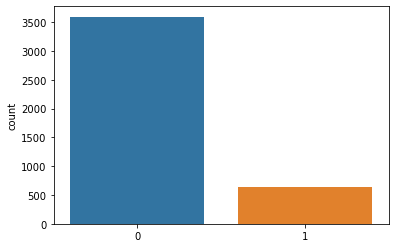

In [4]:
data, numeric_col, categoric_col, strat = loader()

In [5]:
def zero_one_std(df_train, df_test):
    tr_min = df_train.min(axis=0)
    tr_max = df_train.max(axis=0)

    tr_den = (tr_max-tr_min)
    gc.collect()
        
    #numeric pipeline
    df_train = df_train-tr_min
    df_train = df_train/tr_den

    df_test = df_test-tr_min
    df_test = df_test/tr_den

    return df_train, df_test

In [6]:
def eda_pipeline(data, strat, numeric_col, categoric_col):
    train, test, train_strat, _ = train_test_split(data, strat, test_size = 0.33, random_state = 12345, stratify = strat)

    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    
    train_mean = train.mean(axis = 0)
    
    train.fillna(train_mean, inplace=True)
    test.fillna(train_mean, inplace=True)

    y_train, y_test = train.pop('TenYearCHD').values, test.pop('TenYearCHD').values
    
    #categoric pipeline
    df_train = pd.get_dummies(train, columns = categoric_col, drop_first = True)
    df_test = pd.get_dummies(test, columns = categoric_col, drop_first = True)
    
    df_train, df_test = zero_one_std(df_train, df_test)
    
    return(df_train, df_test, y_train, y_test, train_strat)

In [7]:
def cross_validation_pipeline(df_train, y_train, train_strat, logit_param):
    n_fold = 5
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

    pred = np.zeros(df_train.shape[0])

    score = 0

    gc.collect()
    for fold_ , (trn_idx, val_idx) in enumerate(folds.split(df_train, train_strat)):

            gc.collect()

            train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
            valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]


            model = LogisticRegression(**logit_param)

            model.fit(
                train_x, train_y,
            )

            temp = model.predict_proba(valid_x)[:, 1]

            score += roc_auc_score(valid_y, temp)/n_fold

    return score

In [8]:
df_train, df_test, y_train, y_test, train_strat = eda_pipeline(data, strat, numeric_col, categoric_col)

In [9]:
logit_param = {
    'penalty': 'l2',
    'C': 1,
    'max_iter': 1000,
}

In [10]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle = True, random_state = 0)

pred = np.zeros(df_train.shape[0])
pred_test = np.zeros(df_test.shape[0])

score = 0
weight_ = {0: 1, 1: 1/y_train.mean()}
param = np.zeros((n_fold, df_train.shape[1]))

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]

        model = LogisticRegression(**logit_param)
        
        model.fit(
            train_x, train_y,
        )
        
        pred[val_idx] = model.predict_proba(valid_x)[:, 1]
        
        param[fold_, :] = model.coef_
        
        pred_test += (model.predict_proba(df_test)[:,1])/n_fold
        score += roc_auc_score(valid_y, pred[val_idx])/n_fold

        print('Fold: {}; AUC-ROC: {:.4f};  Test AUC-ROC {:.4f}\n'.format(fold_, roc_auc_score(valid_y, pred[val_idx]), roc_auc_score(y_test, model.predict_proba(df_test)[:,1])))
        
print('Final CV Score: {:.4f}'.format(score))
        
test_score = roc_auc_score(y_test, pred_test)
print('Test - Auc : {:.4f}\n'.format(test_score))


Fold: 0; AUC-ROC: 0.7193;  Test AUC-ROC 0.7155

Fold: 1; AUC-ROC: 0.7273;  Test AUC-ROC 0.7183

Fold: 2; AUC-ROC: 0.6863;  Test AUC-ROC 0.7144

Fold: 3; AUC-ROC: 0.7756;  Test AUC-ROC 0.7141

Fold: 4; AUC-ROC: 0.7400;  Test AUC-ROC 0.7115


Final CV Score: 0.7297
Test - Auc : 0.7158



In [11]:
n_fold = 3
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)


for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]
        
        score = valid_x.iloc[:, 8:].mean()
        
        if fold_ == 0:
            vec_test = pd.DataFrame({'Columns': score.index, f'percent{fold_}': score.values})
            vec_train = pd.DataFrame({'Columns': score.index, f'percent{fold_}': train_x.iloc[:, 8:].mean().values})
        else:
            vec_test[f'percent{fold_}'] = score.values
            vec_train[f'percent{fold_}'] = train_x.iloc[:, 8:].mean().values

In [12]:
Imp_df = pd.DataFrame({'Column': df_train.columns, 'Imp': np.abs(param).mean(axis = 0)}).sort_values('Imp', ascending = False).reset_index(drop = True)
tresh = Imp_df.Imp.median()

In [13]:
to_test = ['currentSmoker', 'education', 'BPMeds', 'prevalentHyp', 'heartRate', 'diabetes']

In [14]:
Initial_score = cross_validation_pipeline(df_train, y_train, train_strat, logit_param)

final_score = Initial_score
print(f'Initial Score: {Initial_score}\n')

for col in tqdm(to_test):
    
    temp = data.drop(col, axis = 1).copy()
    temp_categoric_col = [x for x in categoric_col if x != col]
    
    df_train_temp, df_test_temp, y_train_temp, y_test_temp, train_strat_temp = eda_pipeline(temp, strat, numeric_col, temp_categoric_col)
    
    score = cross_validation_pipeline(df_train_temp, y_train_temp, train_strat_temp, logit_param)
    
    if score > final_score:
        
        print(f'Dropping: {col};  Score delta: {score - Initial_score}\n')
        
        final_score = score
        data = temp
        categoric_col = temp_categoric_col
        
print(f'Final score: {final_score}; Delta with initial: {final_score-Initial_score}')

Initial Score: 0.7297079347983261



Dropping: currentSmoker;  Score delta: 0.00016918097589713188

Dropping: education;  Score delta: 0.00023981607583067888

Dropping: heartRate;  Score delta: 0.0004899255733622487


Final score: 0.7301978603716883; Delta with initial: 0.0004899255733622487


In [15]:
df_train, df_test, y_train, y_test, train_strat = eda_pipeline(data, strat, numeric_col, categoric_col)

In [16]:
score = -1
for C in tqdm(np.linspace(.005, 1, 20)):
    logit_param = {
        'penalty': 'l2',
        'C': C,
        'max_iter': 1000,
    }
    temp = cross_validation_pipeline(df_train, y_train, train_strat, logit_param)
    if temp > score:
        
        print(f'C {C} with cv auc: {temp}')
        
        score = temp
        best_c = C

C 0.005 with cv auc: 0.7129442063660952
C 0.057368421052631575 with cv auc: 0.7219610971174059
C 0.10973684210526316 with cv auc: 0.7255079472186421
C 0.16210526315789475 with cv auc: 0.72694555257137
C 0.21447368421052632 with cv auc: 0.727841918588008
C 0.2668421052631579 with cv auc: 0.7283604446475003
C 0.3192105263157895 with cv auc: 0.7289683241378097
C 0.37157894736842106 with cv auc: 0.7293502968212727
C 0.42394736842105263 with cv auc: 0.7295538462751392
C 0.4763157894736842 with cv auc: 0.7297089487252102
C 0.5286842105263158 with cv auc: 0.7298931407537289
C 0.5810526315789474 with cv auc: 0.7300296887107722
C 0.633421052631579 with cv auc: 0.7300887949754774
C 0.6857894736842105 with cv auc: 0.7302049350309572



In [17]:
logit_param = {
    'penalty': 'l2',
    'C': best_c,
    'max_iter': 1000,
}

In [18]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

pred = np.zeros(df_train.shape[0])
pred_test = np.zeros(df_test.shape[0])

score = 0
param = np.zeros((n_fold, df_train.shape[1]))

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]

        model = LogisticRegression(**logit_param)
        
        model.fit(
            train_x, train_y,
        )
        
        pred[val_idx] = model.predict_proba(valid_x)[:, 1]
        
        param[fold_, :] = model.coef_
        
        pred_test += (model.predict_proba(df_test)[:,1])/n_fold
        score += roc_auc_score(valid_y, pred[val_idx])/n_fold

        print('Fold: {}; AUC-ROC: {:.4f};  Test AUC-ROC {:.4f}\n'.format(fold_, roc_auc_score(valid_y, pred[val_idx]), roc_auc_score(y_test, model.predict_proba(df_test)[:,1])))
        
print('Final CV Score: {:.4f}'.format(score))
        
test_score = roc_auc_score(y_test, pred_test)
print('Test - Auc : {:.4f}\n'.format(test_score))


Fold: 0; AUC-ROC: 0.7150;  Test AUC-ROC 0.7180

Fold: 1; AUC-ROC: 0.7282;  Test AUC-ROC 0.7206

Fold: 2; AUC-ROC: 0.6904;  Test AUC-ROC 0.7191

Fold: 3; AUC-ROC: 0.7759;  Test AUC-ROC 0.7176

Fold: 4; AUC-ROC: 0.7416;  Test AUC-ROC 0.7168


Final CV Score: 0.7302
Test - Auc : 0.7197

